In [6]:
from fastPLNmodels.utils import build_block_Sigma, C_from_Sigma, sample_PLN, MSE
import torch
from fastPLNmodels.models import IMPS_PLN, show, log_likelihood, fastPLN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm import tqdm
import torch.linalg as TLA



In [7]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else : 
    device = torch.device('cpu')
    
#device = torch.device('cpu') # think I can't use RTX A5000 right now, will check this later. 
torch.cuda.is_available()
# print('device ', device)

True

In [9]:
device

device(type='cuda', index=0)

### Simulation of the data 

In [48]:
d = 2
n = 200;  p = 200
q = 10

In [49]:
# 0 est pas mal 
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,50))/3 #+ 0.5*torch.eye(p)
true_C = C_from_Sigma(Sigma_sampling, q)
true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p))/3

covariates = torch.randn((n,d))
O =  0+torch.zeros((n,p))
Y, Z, _  = sample_PLN(Sigma_sampling,true_beta, O, covariates)
Y = torch.from_numpy(Y).to(device)
covariates = covariates.to(device)
O = O.to(device)


## Fitting the IMPS based model

In [47]:
batch_size = 10
IMPS_model = IMPS_PLN(q, nb_average_param = 15, nb_average_likelihood = 6)
%time IMPS_model.fit(Y,O,covariates,100, acc = 0.005, batch_size = batch_size, verbose = False, lr = 0.015)

  3%|▎         | 3/100 [00:11<06:20,  3.93s/it]


KeyboardInterrupt: 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


max likelihood : -14.906666562025924


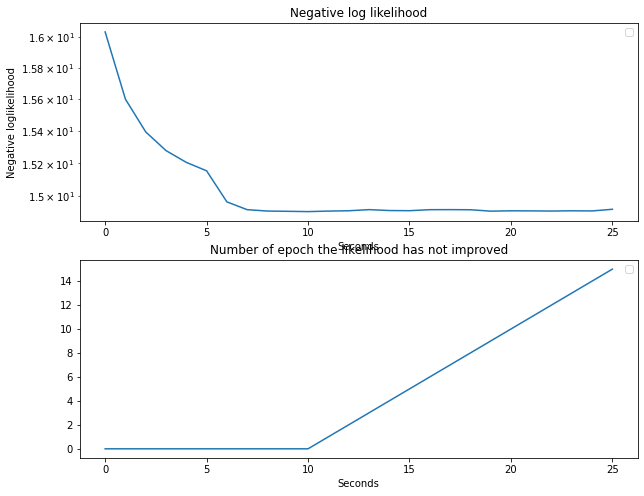

In [14]:
show(IMPS_model)

<AxesSubplot:>

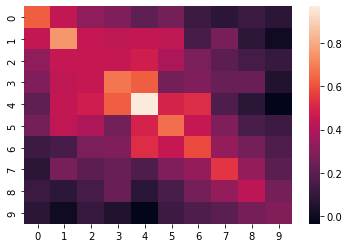

In [15]:
n_a = 0
n_b = 10
sns.heatmap(IMPS_model.Sigma()[n_a:n_b,n_a:n_b])

<AxesSubplot:>

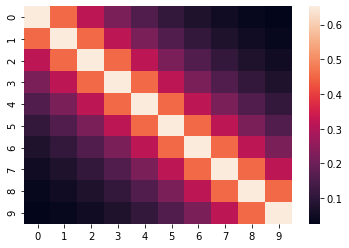

In [14]:
sns.heatmap(Sigma_sampling[n_a:n_b, n_a:n_b])

In [17]:
print('MSE beta', MSE(IMPS_model.beta_mean-true_beta))
print('MSE Sigma', MSE(IMPS_model.Sigma()-true_Sigma_sampling))

MSE beta tensor(0.0096)
MSE Sigma tensor(0.0160)


## fitting the Variational model

In [19]:
fastModel = fastPLN()
%time fastModel.fit(Y,O,covariates, 200, lr = 0.1, tolerance = 10e-4, verbose = True)
#fastModel.C = torch.from_numpy(C_from_Sigma(fastModel.Sigma.detach(), q)).detach()

device  cuda
beta device cuda:0
Iteration number:  0
-------UPDATE-------
Delta :  9.75402170827153
Iteration number:  10
-------UPDATE-------
Delta :  0.18955471169792176
Iteration number:  20
-------UPDATE-------
Delta :  0.041684391252357
Iteration number:  30
-------UPDATE-------
Delta :  0.008650699584322217
Iteration number:  40
-------UPDATE-------
Delta :  0.0020836944022131158
---------------------------------Tolerance 0.001 reached in 47 iterations
CPU times: user 358 ms, sys: 20.4 ms, total: 379 ms
Wall time: 374 ms


In [17]:
print(MSE(fastModel.Sigma-Sigma_sampling))
print(MSE(fastModel.beta-true_beta))

tensor(0.0148)
tensor(0.0098)


<AxesSubplot:>

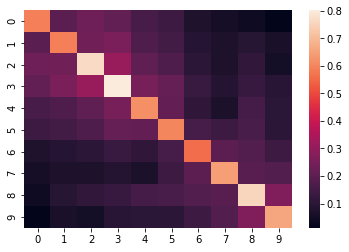

In [18]:
sns.heatmap(fastModel.Sigma.detach())

<AxesSubplot:>

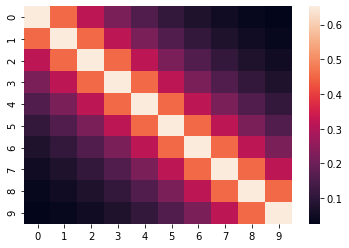

In [19]:
sns.heatmap(Sigma_sampling)

## Computing the likelihoods for each model.

In [18]:
log_like_IMPS_list = list()
log_like_fast_list = list()
for i in tqdm(range(20)): 
    log_like_IMPS_list.append(log_likelihood(Y,O,covariates, IMPS_model.C_mean, IMPS_model.beta_mean, acc = 0.005).detach().item())
    log_like_fast_list.append(log_likelihood(Y,O,covariates, fastModel.C, fastModel.beta.detach(), acc = 0.005).detach().item())

100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


## Comparing both likelihoods 

/home/bastien/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bastien/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


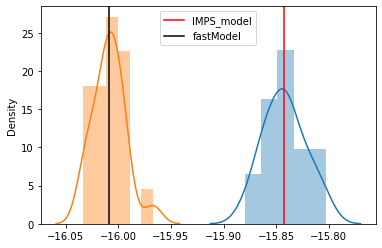

In [19]:
log_like_IMPS = np.mean(np.array(log_like_IMPS_list))
log_like_fast = np.mean(np.array(log_like_fast_list))


sns.distplot(np.array(log_like_IMPS_list))
plt.axvline(log_like_IMPS, label = 'IMPS_model', c = 'red')

sns.distplot(np.array(log_like_fast_list))
plt.axvline(log_like_fast, label = 'fastModel', c = 'black')
plt.legend()

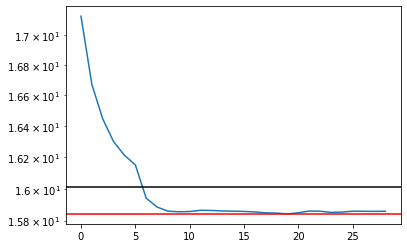

In [20]:
l = IMPS_model.log_likelihood_list
plt.plot(np.arange(0, len(l)), - np.array(l))

plt.axhline(-log_like_fast, c = 'black', label = 'IMPS_model')
plt.axhline(-log_like_IMPS, c = 'red', label = 'fastModel')
plt.yscale('log')

## Comparing the MSEs  

In [156]:
#print('MSE beta for IMPS', MSE(IMPS_model.beta_mean-true_beta))
print('MSE beta for Var App', MSE(fastModel.beta-true_beta).detach())

MSE beta for Var App tensor(0.0994)


In [157]:
#print('MSE Sigma for IMPS: ', MSE(IMPS_model.Sigma()-true_Sigma_sampling))
print('MSE Sigma for IMPS: ', MSE(fastModel.Sigma-true_Sigma_sampling))

MSE Sigma for IMPS:  tensor(0.7629, grad_fn=<MeanBackward0>)


## additional 

In [35]:
IMPS_model.beta_mean

tensor([[-4.2995e-02,  1.4011e-01, -4.1408e-01,  5.7551e-03, -1.0687e-01,
         -4.6650e-01, -4.2465e-01,  7.8986e-02,  4.0549e-01, -4.7068e-01,
         -4.1786e-01, -2.2352e-01, -1.9917e-01,  8.6350e-01,  5.4368e-01,
         -7.2152e-02,  4.6854e-01,  7.7282e-01,  3.0317e-01,  5.7381e-01,
          3.4583e-01,  6.8890e-01,  2.9446e-01,  2.6742e-01,  4.3887e-01,
         -1.8218e-01, -1.4808e-02, -7.7387e-03,  5.1723e-03,  1.5539e-01,
          3.5229e-01,  2.3994e-01,  5.3226e-01, -5.9380e-01, -1.9871e-01,
          3.4108e-01,  4.4736e-01, -1.0495e-02, -1.6037e-01, -1.6108e-01,
         -2.1306e-01, -2.2988e-01,  2.3285e-01, -1.3248e-01,  4.3287e-01,
          6.8753e-01, -1.8264e-02, -1.6492e-01,  4.2250e-01,  3.1361e-01,
         -1.3262e-01,  6.0375e-02,  1.4002e-02,  3.1982e-01,  2.4919e-01,
          3.4656e-01, -1.8159e-01, -4.4648e-01, -9.9878e-02,  5.3317e-02,
          4.4652e-01,  4.3501e-01, -5.2222e-02, -2.3792e-02,  2.0964e-01,
         -2.1938e-01, -6.5044e-01, -1.

In [36]:
true_beta

tensor([[-1.1644e-01,  1.1722e-01, -5.2990e-01, -7.1775e-02, -1.1452e-01,
         -4.4224e-01, -3.4904e-01,  3.7265e-02,  3.5723e-01, -4.2333e-01,
         -4.6506e-01, -2.9983e-01, -2.1870e-01,  7.5900e-01,  4.3989e-01,
         -1.7023e-01,  3.1625e-01,  5.2177e-01,  1.3502e-01,  3.9810e-01,
          2.0435e-01,  5.9238e-01,  2.3352e-01,  2.4914e-01,  4.5444e-01,
         -1.8954e-01, -1.0180e-02, -3.7389e-02, -1.3363e-01,  1.2851e-01,
          3.1765e-01,  2.2889e-01,  4.9238e-01, -6.5377e-01, -1.8661e-01,
          3.5880e-01,  4.0051e-01,  1.2025e-02, -1.7191e-01, -1.9187e-01,
         -2.5920e-01, -3.0213e-01,  2.0843e-01, -1.1795e-01,  3.5241e-01,
          4.9276e-01, -7.7064e-02, -2.3672e-01,  3.6729e-01,  2.9998e-01,
         -1.4670e-01,  5.4048e-03,  5.0838e-03,  3.3024e-01,  2.5163e-01,
          3.9649e-01, -1.5534e-01, -4.3829e-01, -5.9374e-02,  8.8648e-02,
          4.6414e-01,  4.7064e-01, -8.0573e-03, -4.2897e-02,  2.1287e-01,
         -2.1086e-01, -6.5799e-01, -1.